<a href="https://colab.research.google.com/github/VALQUIRIAFABRO/Deep_learning/blob/master/RNN_DeepLearning_UNIP_Func_FULL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Implementação de uma RNN

In [ ]:
import pandas as pd
import numpy as np
import matplotlib #library para gráficos
import matplotlib.pyplot as plt
import sklearn #library de machine learning
from sklearn.datasets import load_breast_cancer #dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import time

### Função Para Inicialização de Pesos

In [ ]:
# Função para inicialização randômica dos parâmetros do modelo
def inicializa_parametros(dims_camada_entrada):
    
    # Dicionário para os parâmetros
    parameters = {}
    
    # Comprimento das dimensões das camadas
    comp = len(dims_camada_entrada)
    
    # Loop pelo comprimento
    for i in range(1, comp):
        
        # Inicialização da matriz de pesos
        parameters["W" + str(i)] = np.random.randn(dims_camada_entrada[i], dims_camada_entrada[i - 1]) * 0.01
        
        # Inicialização do bias
        parameters["b" + str(i)] = np.zeros((dims_camada_entrada[i], 1))
    
    return parameters

In [ ]:
# Função sigmóide
'''
Utilizamos a função sigmóide pois permite converter números para valores entre 0 e 1.
Usada para modelos em que temos que prever a probabilidade como uma saída, sendo qualquer item existente no inmtervalo entre 0 e 1.
'''
def sigmoid(Z):
    A = 1 / (1 + np.exp(-Z))
    return A, Z

In [ ]:
# Função de ativação ReLu (Rectified Linear Unit)
'''
Fynção de ativação para utilizarmos na descida do SGD com retropropagação de erros.
'''
def relu(Z):
    A = abs(Z * (Z > 0))
    return A, Z

In [ ]:
# Operação de ativação
def linear_activation(A, W, b):
    Z = np.dot(W, A) + b
    cache = (A, W, b)
    return Z, cache

#"A": matriz com os dados de entrad / "W": matriz de pesos / "b": bias

### Forward Propagation

In [ ]:
# Movimento forward
def forward(A_prev, W, b, activation):
    
    # Se a função de ativação for Sigmoid
    if activation == "sigmoid":
        Z, linear_cache = linear_activation(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
        
    # Se for ReLu    
    elif activation == "relu":
        Z, linear_cache = linear_activation(A_prev, W, b)
        A, activation_cache = relu(Z)
        
    cache = (linear_cache, activation_cache)
    
    return A, cache

In [ ]:
#Combinando Ativação e Propagação

# Propagação forward
def forward_propagation(X, parameters):
    
    # Lista de valores anteriores (cache)
    caches = []
    
    # Dados de entrada
    A = X
    
    # Comprimento dos parâmetros
    L = len(parameters) // 2
   
    # Loop
    for i in range(1, L):
      
        # Guarda o valor prévio de A
        A_prev = A
        
        # Executa o forward
        A, cache = forward(A_prev, parameters["W" + str(i)], parameters["b" + str(i)], activation = "relu")
        
        # Grava o cache
        caches.append(cache)
    
    # Saída na última camada
    A_last, cache = forward(A, parameters["W" + str(L)], parameters["b" + str(L)], activation = "sigmoid")
    
    # Grava o cache
    caches.append(cache)
    
    return(A_last, caches)

### Função de Custo (Cost Function)

In [ ]:
def calc_custo(A_last, Y):
    
    # Ajusta o shape de Y para obter seu comprimento (total de elementos)
    m = Y.shape[1]
    
    # Calcula o custo comparando valor real e previso
    custo = (-1 / m) * np.sum((Y * np.log(A_last)) + ((1 - Y) * np.log(1 - A_last)))
    
    # Ajusta o shape do custo
    custo = np.squeeze(custo)
    
    return(custo)

### Backward Propagation - Função Sigmóide Backward

In [ ]:
# Função sigmoid para o backpropagation 
# Cálculo da derivada pois temos interessa na informação relacionada a sua variação
def sigmoid_backward(da, Z):
    
    # Calculo da derivada de Z
    dg = (1 / (1 + np.exp(-Z))) * (1 - (1 / (1 + np.exp(-Z))))
    
    # Identificação da alteração na derivada de z
    dz = da * dg
    return dz

#### Backward Propagation - Função ReLu Backward

In [ ]:
def relu_backward(da, Z):
    
    dg = 1 * ( Z >= 0)
    dz = da * dg
    return dz

#Os interesses são os mesmos da função sigmóide no que se refere a informação d avriação.

### Backward Propagation - Ativação Linear Backward

In [ ]:
def linear_backward_function(dz, cache):
    
    # Recebe valor da memória (cache)
    A_prev, W, b = cache
    
    # Shape de m
    m = A_prev.shape[1]
    
    # Calculo da derivada de W (Result. operação com dz)
    dW = (1 / m) * np.dot(dz, A_prev.T)
    
    # Calculo da derivada de b (Result. operação com dz)
    db = (1 / m) * np.sum(dz, axis = 1, keepdims = True)
    
    # Calculo da derivada da operação
    dA_prev = np.dot(W.T, dz)
    
    return dA_prev, dW, db

### Backward Propagation - Ativação Linear Backward

In [ ]:
# Tipo de ativação (relu ou sigmoid)
def linear_activation_backward(dA, cache, activation):
    
    # Extrai o cache
    linear_cache, activation_cache = cache
    
    # Verifica se é ReLu
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward_function(dZ, linear_cache)
        
    # Verifica se é Sigmoid
    if activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward_function(dZ, linear_cache)
        
    return dA_prev, dW, db

### Algoritmo Backpropagation

In [ ]:
def backward_propagation(AL, Y, caches):
    
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    
    # Ajusta o shape de Y
    Y = Y.reshape(AL.shape)
    
    # Calcula a derivada da previsão final da rede(ForwardPropagation) e em seguida recupera o valor atual do cache
    dAL = -((Y / AL) - ((1 - Y) / (1 - AL)))
    current_cache = caches[L - 1]
    
    # Geração da a lista de gradiente para: dados, pesos e bias
    grads["dA" + str(L - 1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    
    # Loop para calculao durante as ativações utilizando a ReLu
    for l in reversed(range(L - 1)):
        
        # Memória atual + Calc de derivadas.
        current_cache = caches[l]
        dA_prev, dW, db = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        
        # Dá infos para os gradientes, usando o índice relacionado
        grads["dA" + str(l)] = dA_prev
        grads["dW" + str(l + 1)] = dW
        grads["db" + str(l + 1)] = db
        
    return grads

### Gradientes e Pesos

In [ ]:
# Atualização de pesos
def atualiza_pesos(parameters, grads, learning_rate):
    
    # Comprimento da estrutura de dados com os parâmetros (pesos e bias)
    L = len(parameters)//2
    
    # Loop para atualização dos pesos
    for l in range(L):
        
        # Atualização dos pesos
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - (learning_rate * grads["dW" + str(l + 1)])
        
        # Atualização do bias
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - (learning_rate * grads["db" + str(l + 1)])
    
    return parameters

#### Implementação da Rede

In [ ]:
# Modelo completo da rede neural
def modeloNN(X, Y, dims_camada_entrada, learning_rate = 0.01, num_iterations = 100):
    #Vejam o tamanho do learning_rate. Comentei durante em aula que as taxas são realmente baixas.
    
    # Lista para receber o custo a cada epoch em train
    custos = []
    
    # Inicializa parâmetros
    parametros = inicializa_parametros(dims_camada_entrada)
    
    # Loop pelo número de iterações (epochs)
    for i in range(num_iterations):
        
        # Forward Propagation
        AL, caches = forward_propagation(X, parametros)
        
        # Calculo do custo
        custo = calc_custo(AL, Y)
        
        # Backward Propagation
        gradientes = backward_propagation(AL, Y, caches)
        
        # Atualização depesos
        parametros = atualiza_pesos(parametros, gradientes, learning_rate)
        
        # Print do valor intermediário do custo, sendo que a redução do custo indica o aprendizado do modelo
        if i % 10 == 0:
            print("Custo Após " + str(i) + " iterações é " + str(custo))
            custos.append(custo)
            
    return parametros, custos 

In [ ]:
# Função para fazer as previsões

def predict(X, parametros):
    AL, caches = forward_propagation(X, parametros)
    return AL

# Notme que não há backpropagation, pois conforme as previsões surgem, os valores dos pesos mais aderentes acabam ficando conhecidos.

# Mais uma vez prevermos a saída relacionada a ter câncer ou não.

In [ ]:
#Para informações do dataset
#Link: https://scikit-learn.org/stable/datasets/index.html#breast-cancer-dataset

# Carregamos o conjunto
cancer = load_breast_cancer()

print(type(cancer))

<class 'sklearn.utils.Bunch'>


In [ ]:
# Carregamos o dataset
cancerDF = pd.DataFrame(columns = load_breast_cancer()["feature_names"], data = load_breast_cancer()["data"])

In [ ]:
cancerDF.shape

(569, 30)

In [ ]:
cancerDF.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:
# Identificamos e separamos nosso target
target = load_breast_cancer()["target"]

In [ ]:
type(target)

numpy.ndarray

In [ ]:
# Então esperamos um array entre 0 e 1.
target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,

In [ ]:
print("Total da Classe do tipo Benigno: ",np.count_nonzero(target == 1))
print("="*15)
print("Total da Classe do tipo Maligno: ",np.count_nonzero(target == 0))

Total da Classe do tipo Benigno:  357
Total da Classe do tipo Maligno:  212


In [ ]:
# Dicionário para os labels
labels = {}

# Nomes das classes da variável target
target_names = load_breast_cancer()["target_names"]

# Mapeamento
for i in range(len(target_names)):
    labels.update({i:target_names[i]})  

In [ ]:
# Labels - Lembrete: Sempre trabalhamos com números.
labels

{0: 'malignant', 1: 'benign'}

In [ ]:
# Entregamos as variáveis preditoras para X
X = np.array(cancerDF)

In [ ]:
# Divisão de dados de entrada e saída em treino e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, target, test_size = 0.20, shuffle = True)

In [ ]:
# Verificação de estado dos nossos dados X,y (Treino)
print("Dados de Treino")
print(X_treino.shape)
print(y_treino.shape)
print("="*20)
print("Dados de Teste")
# Verificação de estado dos nossos dados X,y (Teste)
print(X_teste.shape)
print(y_teste.shape)

Dados de Treino
(455, 30)
(455,)
Dados de Teste
(114, 30)
(114,)


In [ ]:
# Ajuste nos dados de entrada
X_treino = X_treino.T
X_teste = X_teste.T

# Ajuste nos dados de saída
y_treino = y_treino.reshape(1, len(y_treino))
y_teste = y_teste.reshape(1, len(y_teste))

In [ ]:
# Dimensões de entrada com número de neurônios 
dims_camada_entrada = [X_treino.shape[0], 50, 20, 5, 1]

In [ ]:
# Treinando o modelo

iniProc = time.time()
parametros, custo = modeloNN(X = X_treino, 
                             Y = y_treino, 
                             dims_camada_entrada = dims_camada_entrada, num_iterations = 3000, learning_rate = 0.0075)

print("Treinamento durou %2.f segundos " % (time.time() - iniProc))

Custo Após 0 iterações é 0.693141785022814
Custo Após 10 iterações é 0.692122551572999
Custo Após 20 iterações é 0.6911408219892857
Custo Após 30 iterações é 0.6901952105433395
Custo Após 40 iterações é 0.6892843801169861
Custo Após 50 iterações é 0.6884070425650788
Custo Após 60 iterações é 0.6875619566696122
Custo Após 70 iterações é 0.6867479249150882
Custo Após 80 iterações é 0.6859637937057317
Custo Após 90 iterações é 0.6852084503114492
Custo Após 100 iterações é 0.6844808241089058
Custo Após 110 iterações é 0.6837798825555318
Custo Após 120 iterações é 0.6831046318707765
Custo Após 130 iterações é 0.6824541134952594
Custo Após 140 iterações é 0.6818274035431796
Custo Após 150 iterações é 0.6812236124401857
Custo Após 160 iterações é 0.680641882699577
Custo Após 170 iterações é 0.6800813878800794
Custo Após 180 iterações é 0.6795413327604377
Custo Após 190 iterações é 0.6790209492882299
Custo Após 200 iterações é 0.6785194977646223
Custo Após 210 iterações é 0.6780362656454236
Cu

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(0.5, 1.0, 'Erros em Treinamento')

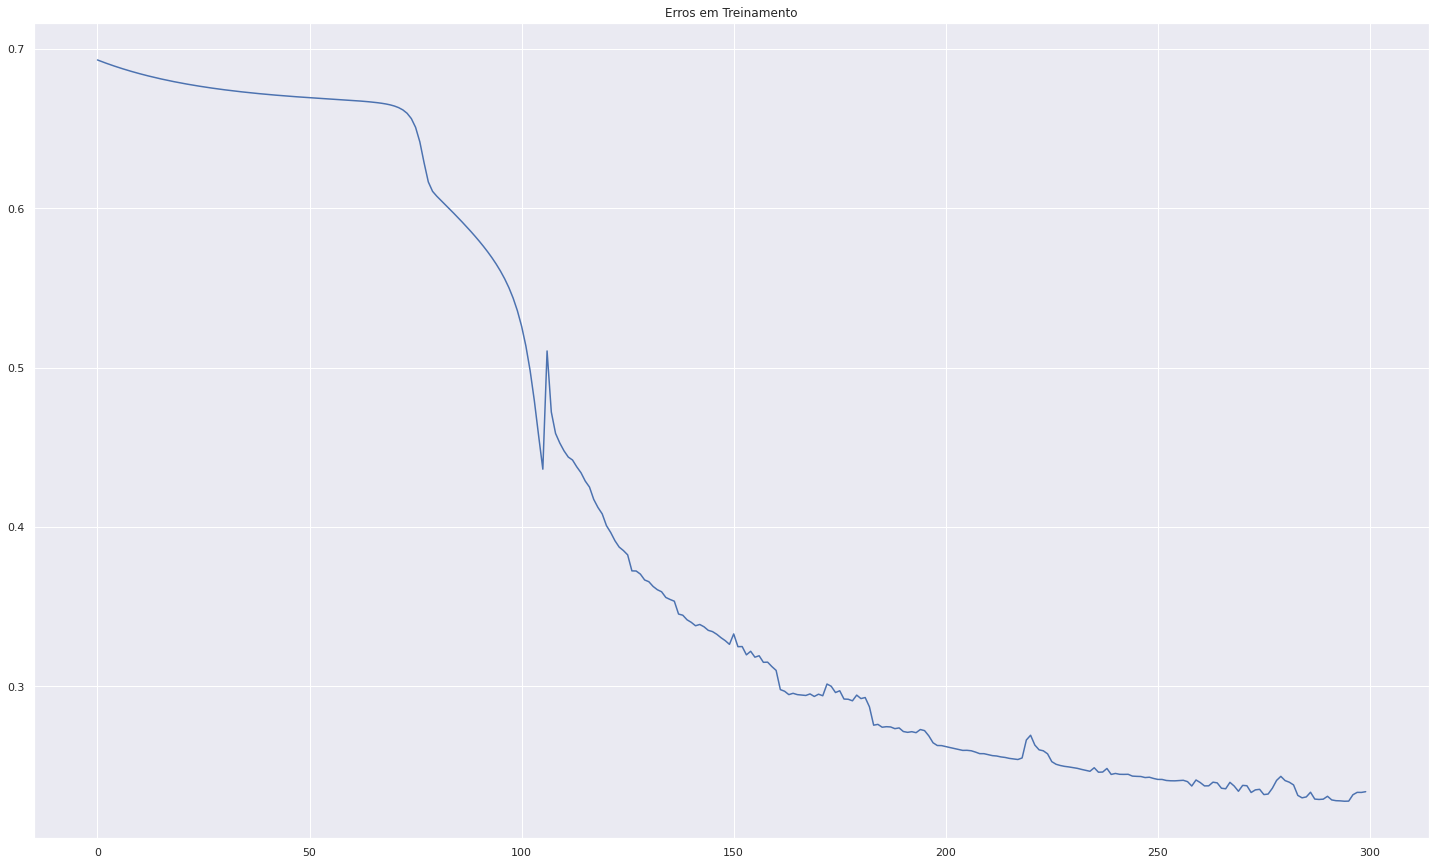

In [ ]:
import seaborn as sns
# Plot do erro no treinamento
sns.set(rc={"figure.figsize":(25,15)});
plt.plot(custo)
plt.title("Erros em Treinamento")

In [ ]:
# Previsões em treino
y_pred_treino = predict(X_treino, parametros)

In [ ]:
# Visualização das previsões
y_pred_treino

array([[4.66918129e-01, 2.44130425e-04, 6.94915456e-01, 8.74939680e-01,
        2.49099957e-01, 8.59556950e-01, 2.74054333e-04, 8.40260961e-01,
        8.70648993e-01, 8.75315788e-01, 8.74772598e-01, 5.44579530e-08,
        8.74807518e-01, 8.75046412e-01, 8.75035769e-01, 8.74647572e-01,
        7.70377741e-01, 8.75112291e-01, 1.78102748e-01, 8.74881342e-01,
        7.04837410e-01, 8.35816797e-01, 1.73822375e-02, 8.74697664e-01,
        4.27908961e-01, 8.74829774e-01, 6.60284630e-01, 8.74920638e-01,
        8.71719132e-01, 8.75147362e-01, 5.00444014e-02, 1.78225110e-08,
        3.84802134e-03, 8.74937347e-01, 3.07596312e-04, 8.74705453e-01,
        8.74844648e-01, 8.67081298e-01, 8.74561509e-01, 8.74906557e-01,
        9.53385728e-02, 8.37704832e-01, 8.71138675e-01, 8.68235323e-01,
        5.00065628e-02, 8.74798702e-01, 8.74764904e-01, 8.74764703e-01,
        1.31420463e-01, 5.27672623e-01, 8.74701170e-01, 5.70647859e-04,
        8.07125682e-01, 8.74789096e-01, 1.19443405e-02, 8.748974

In [ ]:
# Ajustamos o shape para treino
y_pred_treino = y_pred_treino.reshape(-1)
y_treino = y_treino.reshape(-1)
y_pred_treino > 0.5

array([False, False,  True,  True, False,  True, False,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True, False,  True, False,  True,  True,
        True,  True,  True, False, False, False,  True, False,  True,
        True,  True,  True,  True, False,  True,  True,  True, False,
        True,  True,  True, False,  True,  True, False,  True,  True,
       False,  True, False,  True,  True, False,  True,  True,  True,
       False, False,  True,  True, False,  True,  True, False,  True,
        True,  True, False,  True,  True, False, False,  True,  True,
        True, False, False,  True, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True, False, False, False,  True,
        True, False, False,  True,  True, False,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True, False, False,
        True,  True,

In [ ]:
# Conversão das previsões binário de classe (0 ou 1), usando como threshold o valor de 0.5 da probabilidade
y_pred_treino = 1 * (y_pred_treino > 0.5)
y_pred_treino

array([0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0,

In [ ]:
# Calculo da acurácia comparando valor real com valor previsto
aval_treino = sum(1 * (y_pred_treino == y_treino)) / len(y_pred_treino) * 100
print("Acurácia em Treino: " + str(aval_treino))

Acurácia em Treino: 92.52747252747253


In [ ]:
print(classification_report(y_treino, y_pred_treino, target_names = ['Maligno', 'Benigno']))

              precision    recall  f1-score   support

     Maligno       0.97      0.83      0.90       174
     Benigno       0.90      0.98      0.94       281

    accuracy                           0.93       455
   macro avg       0.94      0.91      0.92       455
weighted avg       0.93      0.93      0.92       455



In [ ]:
# Previsões usando dados de teste
y_pred_teste = predict(X_teste, parametros)
y_pred_teste

array([[8.74784698e-01, 8.74857877e-01, 8.20234176e-01, 6.89158209e-13,
        8.71500539e-01, 6.22630290e-01, 7.96448623e-01, 1.92132202e-05,
        8.74814529e-01, 8.74823837e-01, 8.74812111e-01, 8.75110504e-01,
        8.74768834e-01, 8.75037441e-01, 8.74615081e-01, 1.78527862e-01,
        3.90261785e-06, 8.73707197e-01, 8.71225604e-01, 3.22337459e-02,
        8.57196142e-01, 8.64929997e-01, 8.74841088e-01, 8.17914823e-01,
        8.74813665e-01, 5.68379137e-01, 8.75036167e-01, 8.39197949e-01,
        8.75110085e-01, 8.74758541e-01, 8.74733693e-01, 8.02563044e-01,
        8.74885303e-01, 8.74986535e-01, 4.05235969e-02, 8.75171395e-01,
        8.62948905e-01, 8.74687932e-01, 8.67506735e-01, 9.29569059e-05,
        8.01170405e-01, 8.75055744e-01, 2.31755744e-01, 6.29669624e-01,
        8.68172348e-01, 1.06359852e-04, 8.07800469e-01, 8.74964938e-01,
        8.74925357e-01, 8.74863317e-01, 8.74705534e-01, 5.14905643e-04,
        1.71049541e-03, 5.51857534e-01, 7.69414077e-01, 8.749806

In [ ]:
# Ajuste dos shapes
y_pred_teste = y_pred_teste.reshape(-1)
y_teste = y_teste.reshape(-1)

# Conversão das previsões binário)referente a classe)
y_pred_teste = 1 * (y_pred_teste > 0.5)

# Resultado das previsões em si
y_pred_teste

array([1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1])

In [ ]:
# Acurácia
acuraciaFim = sum(1 * (y_pred_teste == y_teste)) / len(y_pred_teste) * 100
print("Acurácia em dados de Teste: " + str(acuraciaFim))

#Propositalmente um parâmetro foi ajustado para fornecer uma saída relativamente baixa. Faz parte da atividade identificar o(s) parâmetro(s) em questão.

Acurácia em dados de Teste: 91.22807017543859


In [ ]:
print(classification_report(y_teste, y_pred_teste, target_names = ['Maligno', 'Benigno']))

              precision    recall  f1-score   support

     Maligno       0.97      0.76      0.85        38
     Benigno       0.89      0.99      0.94        76

    accuracy                           0.91       114
   macro avg       0.93      0.88      0.90       114
weighted avg       0.92      0.91      0.91       114



### Atividade extra: Pesquisar o que é Precision, Recall, F1-score, Support